In [12]:
from pyannote.audio import Pipeline

In [13]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization",
                                    use_auth_token="your_token")

## Walk thru recording directory

In [14]:
import os
import librosa

In [15]:
categories = [c for c in os.listdir("./audios/")]

categories

['Abandoned Cars',
 'Aggressive Drivers',
 'Check Welfare',
 'Damage to Property',
 'Durgs-Pros',
 'Found Property',
 'Illegally Parking',
 'Lost-stolen',
 'Noise Violation']

In [16]:
recordings = {}

for c in categories:
    recordings[c] = [r for r in os.listdir("./audios/" + c + "/")]

In [17]:
integer_encoding_map = {
    i:j for i, j in zip(categories, range(len(categories)))
}

integer_encoding_map["UNKOWN"] = 9

integer_encoding_map["Drug-Pros"] = 4
integer_encoding_map["Drugs-Pros"] = 4
integer_encoding_map["Illegal Parking"] = 6

integer_encoding_map

{'Abandoned Cars': 0,
 'Aggressive Drivers': 1,
 'Check Welfare': 2,
 'Damage to Property': 3,
 'Durgs-Pros': 4,
 'Found Property': 5,
 'Illegally Parking': 6,
 'Lost-stolen': 7,
 'Noise Violation': 8,
 'UNKOWN': 9,
 'Drug-Pros': 4,
 'Drugs-Pros': 4,
 'Illegal Parking': 6}

## Get speaker diarization

In [18]:
import re
from tqdm import tqdm
import shutil
from pydub import AudioSegment

In [19]:
def millisec(timeStr):
    spl = timeStr.split(":")
    s = (int)((int(spl[0]) * 60 * 60 + int(spl[1]) * 60 + float(spl[2]) )* 1000)
    return s

In [20]:
def clear_dir(path):
    folder = path
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [21]:
from pydub import AudioSegment

def mp3_to_wav(audio_file_path):
    sound = AudioSegment.from_mp3(audio_file_path)
    audio_file_path = audio_file_path.split('.')[0] + '.wav'
    sound.export(audio_file_path, format="wav")
    return audio_file_path

In [22]:
# for c in tqdm(recordings.keys()):
#     cur_path = "./audios/" + c + "/speaker_diarization"
    
#     for r in recordings[c]:
#         fname = "./audios/" + c + "/" + r
#         if ".mp3" in fname:
#             fname = mp3_to_wav(fname)
#         dz = pipeline(fname)
#         # print(dz)
#         with open(cur_path + "/{}.txt".format(r), "w") as text_file:
#             text_file.write(str(dz))

## Transcribe audios

In [23]:
import whisper

In [24]:
whisper_model = whisper.load_model("medium.en")

spacermilli = 2000

100%|█████████████████████████████████████| 1.42G/1.42G [01:09<00:00, 22.1MiB/s]


In [ ]:
for c in recordings.keys():
    cur_path = "./audios/" + c
    
    dz_files = [d for d in os.listdir(cur_path+ "/speaker_diarization/")]
    
    for df in tqdm(dz_files):
        cur_dz = open("./audios/" + c + "/speaker_diarization/" + df).read().splitlines()
        
        groups = []
        g = []
        lastend = 0
        
        for dz in cur_dz:
            if g and (g[0].split()[-1] != dz.split()[-1]):
                groups.append(g)
                g = []
                
            g.append(dz)
            
            end = re.findall('[0-9]+:[0-9]+:[0-9]+\.[0-9]+', string=dz)[1]
            end = millisec(end)
            
            if lastend > end:
                groups.append(g)
                g = []
            else:
                lastend = end
        if g:
            groups.append(g)
        
        audio_name = df[:-4]
        
        if ".mp3" in audio_name:
            audio = AudioSegment.from_mp3("./audios/" + c + "/" + audio_name)
        else:
            audio = AudioSegment.from_wav("./audios/" + c + "/" + audio_name)
        
        clear_dir("./temp_wavs")
        
        gidx = -1
        for g in groups:
            start = re.findall('[0-9]+:[0-9]+:[0-9]+\.[0-9]+', string=g[0])[0]
            end = re.findall('[0-9]+:[0-9]+:[0-9]+\.[0-9]+', string=g[-1])[1]
            start = millisec(start) #- spacermilli
            end = millisec(end)  #- spacermilli
            # print(start, end)
            gidx += 1
            audio[start:end].export("./temp_wavs/" + str(gidx) + '.wav', format='wav')
        
        txt_file = []
        
        for g in groups:
            startStr = str(re.findall('[0-9]+:[0-9]+:[0-9]+\.[0-9]+', string=g[0])[0])
            endStr = str(re.findall('[0-9]+:[0-9]+:[0-9]+\.[0-9]+', string=g[-1])[1])

            speaker = g[0].split()[-1]
        
            transcriptions = whisper_model.transcribe("./temp_wavs/" + str(groups.index(g)) + ".wav")
            txt_file.append("[{}]-->[{}] {} {}\n".format(startStr, endStr, speaker, transcriptions["text"]))
        
        with open("./audios/" + c + "/audio_transcriptions/{}.txt".format(audio_name), "w", encoding="utf-8") as text_file:
            s = "".join(txt_file)
            text_file.write(s)

 62%|███████████████████████████████████████████████████                                | 8/13 [05:02<03:22, 40.53s/it]

## Conversation analysis

In [11]:
import pandas as pd
import nltk
import string
from nltk.stem import WordNetLemmatizer  
from nltk.stem import PorterStemmer

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [102]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RexZC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RexZC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RexZC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RexZC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RexZC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
def predict_based_on_keywords(description):
    res = {
        "Abandoned Cars": 0,
        "Aggressive Drivers": 0,
        "Check Welfare": 0,
        "Damage to Property": 0,
        "Drug-Pros": 0,
        "Found Property": 0,
        "Illegal Parking": 0,
        "Lost-stolen": 0,
        "Noise Violation": 0
    }
    
    ref_res = {
        "Abandoned Cars": 0,
        "Aggressive Drivers": 0,
        "Check Welfare": 0,
        "Damage to Property": 0,
        "Drug-Pros": 0,
        "Found Property": 0,
        "Illegal Parking": 0,
        "Lost-stolen": 0,
        "Noise Violation": 0
    }
    
    description = nltk.tokenize.word_tokenize(description)
    
    for item in description:
        if 'aban' in item or 'left' in item:
            res["Abandoned Cars"] += 1
        
        if 'reckless' in item:
            res["Aggressive Drivers"] += 1
        
        if 'welf' in item:
            res['Check Welfare'] += 1
        
        if 'damage' in item:
            res["Damage to Property"] += 1
        
        if "drug" in item or "solic" in item:
            res["Drug-Pros"] += 1
        
        if "found" in item:
            res["Found Property"] += 1
        
        if 'park' in item:
            res['Illegal Parking'] += 1
        
        if "lost" in item or "stolen" in item:
            res["Lost-stolen"] += 1
        
        if 'loud' in item:
            res["Noise Violation"] += 1
        
    if res != ref_res:
        prediction = sorted(res.items(), key=lambda item: item[1])[::-1][0][0]
    
    else:
        prediction = "UNKOWN"
    
    return prediction
    

#### Analysis on caller's transcriptions alone

Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Accuracy on Abandoned Cars: 0.15384615384615385
Prediction: Drug-Pros  && Gold: Aggressive Drivers
Prediction: Drug-Pros  && Gold: Aggressive Drivers
Prediction: Illegal Parking  && Gold: Aggressive Drivers
Prediction: Illegal Parking  && Gold: Aggressive Drivers
Prediction: Illegal Parking  && Gold: Aggressive Drivers
Prediction: UNKOWN  && Gold: Aggressive Drivers
Predict

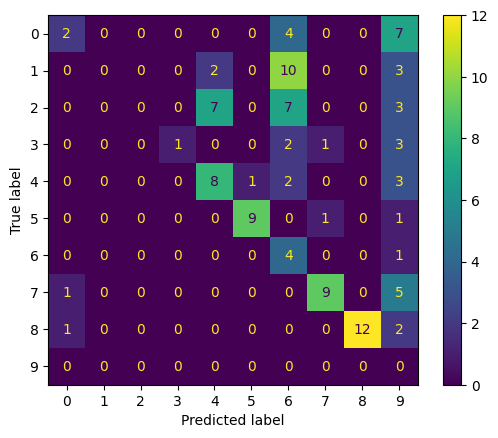

In [14]:
audio_transcriptions_separated_by_speakers = {}
# id: audio_name
# cate: category
# speaker: [list of transcriptions]
size = 0
acc = 0
preds = []
golds = []

for c in recordings.keys():
    tmp_size = 0
    tmp_acc = 0
    audio_transcriptions = [at for at in os.listdir("./audios/" + c + "/audio_transcriptions/")]
    audio_transcriptions_separated_by_speakers = {
        "category": None,
        "audio_name": None,
        "speakers":{}
    }
    
    for at in audio_transcriptions:
        size += 1
        tmp_size += 1
        audio_transcriptions_separated_by_speakers['category'] = c
        audio_transcriptions_separated_by_speakers['audio_name'] = at[:-4]
        cur_audio_transcription = open("./audios/" + c + "/audio_transcriptions/" + at, encoding='utf-8').read().splitlines()
        
        speaker_list = []
        for spk in cur_audio_transcription:
            speaker_list.append(spk.split(" ")[1])
        
        # speaker_list[0] is the 'reporting' voice
        for spk in speaker_list:
            if spk == "SPEAKER_00":
                speaker_list.remove(spk)
        
        dispatcher = [speaker_list[0]]
        caller = []
        for spk in speaker_list:
            if spk != speaker_list[0] and spk not in caller:
                caller.append(spk)
        
        for t in cur_audio_transcription:
            # duration = t.split(" ")[0]
            speaker = t.split(" ")[1]
            texts = " ".join(t.split(" ")[2:])
            
            # print(duration, speaker, texts)
            
            # audio_transcriptions_separated_by_speakers['duration'] = duration
            if speaker not in audio_transcriptions_separated_by_speakers["speakers"]:
                audio_transcriptions_separated_by_speakers["speakers"][speaker] = [texts]
            else:
                audio_transcriptions_separated_by_speakers["speakers"][speaker].append(texts)
        
        # print(audio_transcriptions_separated_by_speakers)
        
        caller_text = ""
        for cllr in caller:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][cllr]:
                caller_text += txt
        
        dispatcher_text = ""
        for dsptchr in dispatcher:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][dsptchr]:
                dispatcher_text += txt
        
        # print(predict_based_on_keywords(caller_text))
        # print(predict_based_on_keywords(dispatcher_text))
        
        print("Prediction: {}  && Gold: {}".format(predict_based_on_keywords(caller_text), audio_transcriptions_separated_by_speakers["category"]))
        
        preds.append(integer_encoding_map[predict_based_on_keywords(caller_text)])
        golds.append(integer_encoding_map[audio_transcriptions_separated_by_speakers['category']])
        
        if predict_based_on_keywords(caller_text) == audio_transcriptions_separated_by_speakers['category']:
            acc += 1
            tmp_acc += 1
            
    print("Accuracy on {}: {}".format(audio_transcriptions_separated_by_speakers["category"], tmp_acc/tmp_size))
    print("=============================================")
        
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Accuracy on caller's transcriptions only: {}".format(acc/size))    

#### Analysis on dispatcher's transcriptions alone

Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Lost-stolen  && Gold: Abandoned Cars
Prediction: Lost-stolen  && Gold: Abandoned Cars
Prediction: Lost-stolen  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Accuracy on Abandoned Cars: 0.46153846153846156
Prediction: UNKOWN  && Gold: Aggressive Drivers
Prediction: UNKOWN  && Gold: Aggressive Drivers
Prediction: UNKOWN  && Gold: Aggressive Drivers
Prediction: UNKOWN  && Gold: Aggressive Drivers
Prediction: Abandoned Cars  && Gold: Aggressive Drivers
Prediction: Illegal Parking  && Gold: Aggr

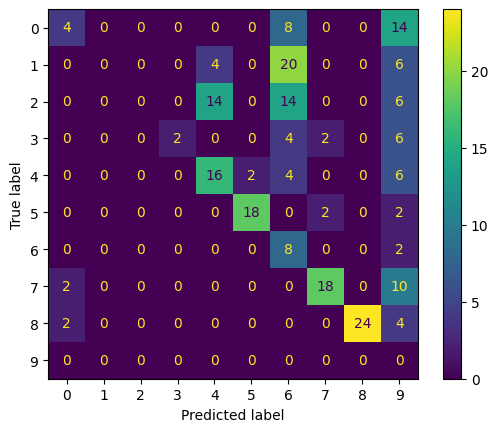

In [15]:
audio_transcriptions_separated_by_speakers = {}
# id: audio_name
# cate: category
# speaker: [list of transcriptions]
size = 0
acc = 0


for c in recordings.keys():
    tmp_size = 0
    tmp_acc = 0
    audio_transcriptions = [at for at in os.listdir("./audios/" + c + "/audio_transcriptions/")]
    audio_transcriptions_separated_by_speakers = {
        "category": None,
        "audio_name": None,
        "speakers":{}
    }
    
    for at in audio_transcriptions:
        size += 1
        tmp_size += 1
        audio_transcriptions_separated_by_speakers['category'] = c
        audio_transcriptions_separated_by_speakers['audio_name'] = at[:-4]
        cur_audio_transcription = open("./audios/" + c + "/audio_transcriptions/" + at, encoding='utf-8').read().splitlines()
        
        speaker_list = []
        for spk in cur_audio_transcription:
            speaker_list.append(spk.split(" ")[1])
        
        # speaker_list[0] is the 'reporting' voice
        for spk in speaker_list:
            if spk == "SPEAKER_00":
                speaker_list.remove(spk)
        
        dispatcher = [speaker_list[0]]
        caller = []
        for spk in speaker_list:
            if spk != speaker_list[0] and spk not in caller:
                caller.append(spk)
        
        for t in cur_audio_transcription:
            # duration = t.split(" ")[0]
            speaker = t.split(" ")[1]
            texts = " ".join(t.split(" ")[2:])
            
            # print(duration, speaker, texts)
            
            # audio_transcriptions_separated_by_speakers['duration'] = duration
            if speaker not in audio_transcriptions_separated_by_speakers["speakers"]:
                audio_transcriptions_separated_by_speakers["speakers"][speaker] = [texts]
            else:
                audio_transcriptions_separated_by_speakers["speakers"][speaker].append(texts)
        
        # print(audio_transcriptions_separated_by_speakers)
        
        caller_text = ""
        for cllr in caller:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][cllr]:
                caller_text += txt
        
        dispatcher_text = ""
        for dsptchr in dispatcher:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][dsptchr]:
                dispatcher_text += txt
        
        # print(predict_based_on_keywords(caller_text))
        # print(predict_based_on_keywords(dispatcher_text))
        
        print("Prediction: {}  && Gold: {}".format(predict_based_on_keywords(dispatcher_text), audio_transcriptions_separated_by_speakers["category"]))
        
        preds.append(integer_encoding_map[predict_based_on_keywords(caller_text)])
        golds.append(integer_encoding_map[audio_transcriptions_separated_by_speakers['category']])
        
        if predict_based_on_keywords(dispatcher_text) == audio_transcriptions_separated_by_speakers['category']:
            acc += 1
            tmp_acc += 1
            
    print("Accuracy on {}: {}".format(audio_transcriptions_separated_by_speakers["category"], tmp_acc/tmp_size))
    print("=============================================")

    
cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Accuracy on dispatcher's transcriptions only: {}".format(acc/size))    

#### Analysis on both transcriptions

Prediction: UNKOWN  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Lost-stolen  && Gold: Abandoned Cars
Prediction: Lost-stolen  && Gold: Abandoned Cars
Prediction: Abandoned Cars  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Prediction: Illegal Parking  && Gold: Abandoned Cars
Accuracy on Abandoned Cars: 0.3076923076923077
Prediction: Drug-Pros  && Gold: Aggressive Drivers
Prediction: Drug-Pros  && Gold: Aggressive Drivers
Prediction: Illegal Parking  && Gold: Aggressive Drivers
Prediction: Illegal Parking  && Gold: Aggressive Drivers
Prediction: Illegal Parking  && Gold: Aggressive Drivers
Prediction: 

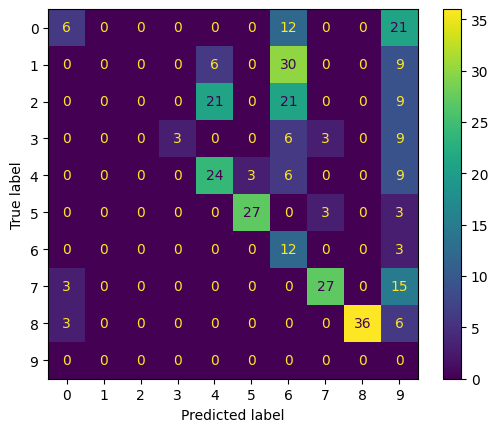

In [16]:
audio_transcriptions_separated_by_speakers = {}
# id: audio_name
# cate: category
# speaker: [list of transcriptions]
size = 0
acc = 0


for c in recordings.keys():
    tmp_size = 0
    tmp_acc = 0
    audio_transcriptions = [at for at in os.listdir("./audios/" + c + "/audio_transcriptions/")]
    audio_transcriptions_separated_by_speakers = {
        "category": None,
        "audio_name": None,
        "speakers":{}
    }
    
    for at in audio_transcriptions:
        size += 1
        tmp_size += 1
        audio_transcriptions_separated_by_speakers['category'] = c
        audio_transcriptions_separated_by_speakers['audio_name'] = at[:-4]
        cur_audio_transcription = open("./audios/" + c + "/audio_transcriptions/" + at, encoding='utf-8').read().splitlines()
        
        speaker_list = []
        for spk in cur_audio_transcription:
            speaker_list.append(spk.split(" ")[1])
        
        # speaker_list[0] is the 'reporting' voice
        for spk in speaker_list:
            if spk == "SPEAKER_00":
                speaker_list.remove(spk)
        
        dispatcher = [speaker_list[0]]
        caller = []
        for spk in speaker_list:
            if spk != speaker_list[0] and spk not in caller:
                caller.append(spk)
        
        for t in cur_audio_transcription:
            # duration = t.split(" ")[0]
            speaker = t.split(" ")[1]
            texts = " ".join(t.split(" ")[2:])
            
            # print(duration, speaker, texts)
            
            # audio_transcriptions_separated_by_speakers['duration'] = duration
            if speaker not in audio_transcriptions_separated_by_speakers["speakers"]:
                audio_transcriptions_separated_by_speakers["speakers"][speaker] = [texts]
            else:
                audio_transcriptions_separated_by_speakers["speakers"][speaker].append(texts)
        
        # print(audio_transcriptions_separated_by_speakers)
        
        caller_text = ""
        for cllr in caller:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][cllr]:
                caller_text += txt
        
        dispatcher_text = ""
        for dsptchr in dispatcher:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][dsptchr]:
                dispatcher_text += txt
        
        # print(predict_based_on_keywords(caller_text))
        # print(predict_based_on_keywords(dispatcher_text))
        
        print("Prediction: {}  && Gold: {}".format(predict_based_on_keywords(caller_text + dispatcher_text), audio_transcriptions_separated_by_speakers["category"]))
        
        preds.append(integer_encoding_map[predict_based_on_keywords(caller_text)])
        golds.append(integer_encoding_map[audio_transcriptions_separated_by_speakers['category']])
        
        if predict_based_on_keywords(caller_text + dispatcher_text) == audio_transcriptions_separated_by_speakers['category']:
            acc += 1
            tmp_acc += 1
            
    print("Accuracy on {}: {}".format(audio_transcriptions_separated_by_speakers["category"], tmp_acc/tmp_size))
    print("=============================================")

cm = confusion_matrix(golds, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Accuracy on both transcriptions: {}".format(acc/size))    

In [17]:
### Miss-prediction impacts?
### Performance diff on Our keywords?
### Decision tree-like diagram?

In [18]:
integer_encoding_map

{'Abandoned Cars': 0,
 'Aggressive Drivers': 1,
 'Check Welfare': 2,
 'Damage to Property': 3,
 'Durgs-Pros': 4,
 'Found Property': 5,
 'Illegally Parking': 6,
 'Lost-stolen': 7,
 'Noise Violation': 8,
 'UNKOWN': 9,
 'Drug-Pros': 4,
 'Drugs-Pros': 4,
 'Illegal Parking': 6}

## Get topk words

In [93]:
corpus_per_category = {}

for c in recordings.keys():
    print("Dealing with {}".format(c))
    tmp_size = 0
    tmp_acc = 0
    audio_transcriptions = [at for at in os.listdir("./audios/" + c + "/audio_transcriptions/")]
    audio_transcriptions_separated_by_speakers = {
        "category": None,
        "audio_name": None,
        "speakers":{}
    }
    corpus_per_category[c] = ""
    
    for at in audio_transcriptions:
        size += 1
        tmp_size += 1
        audio_transcriptions_separated_by_speakers['category'] = c
        audio_transcriptions_separated_by_speakers['audio_name'] = at[:-4]
        cur_audio_transcription = open("./audios/" + c + "/audio_transcriptions/" + at, encoding='utf-8').read().splitlines()
        
        speaker_list = []
        for spk in cur_audio_transcription:
            speaker_list.append(spk.split(" ")[1])
        
        # speaker_list[0] is the 'reporting' voice
        for spk in speaker_list:
            if spk == "SPEAKER_00":
                speaker_list.remove(spk)
        
        dispatcher = [speaker_list[0]]
        caller = []
        for spk in speaker_list:
            if spk != speaker_list[0] and spk not in caller:
                caller.append(spk)
        
        for t in cur_audio_transcription:
            # duration = t.split(" ")[0]
            speaker = t.split(" ")[1]
            texts = " ".join(t.split(" ")[2:])
            
            if speaker not in audio_transcriptions_separated_by_speakers["speakers"]:
                audio_transcriptions_separated_by_speakers["speakers"][speaker] = [texts]
            else:
                audio_transcriptions_separated_by_speakers["speakers"][speaker].append(texts)
        
        # print(audio_transcriptions_separated_by_speakers)
        
        caller_text = ""
        for cllr in caller:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][cllr]:
                caller_text += txt
        
        dispatcher_text = ""
        for dsptchr in dispatcher:
            for txt in audio_transcriptions_separated_by_speakers["speakers"][dsptchr]:
                dispatcher_text += txt
        
        all_text = caller_text + dispatcher_text
        # all_text = caller_text
    
    corpus_per_category[c] += all_text

Dealing with Abandoned Cars
Dealing with Aggressive Drivers
Dealing with Check Welfare
Dealing with Damage to Property
Dealing with Durgs-Pros
Dealing with Found Property
Dealing with Illegally Parking
Dealing with Lost-stolen
Dealing with Noise Violation


In [100]:
def word_filter(word_list):
    
    res = []
    
    greeting_words = [
        "okay",
        "yeah",
        "yes",
        "thank",
        "bye"
    ]
    
    insignificant_words = [
        "n't",
        "'ll",
        "'re",
        "'m",
        "'s",
        "'ve",
        
        "like",
        "know",
        "think",
        "right",         
        'going',
        'get',
        'got',
        
        "see",
        "name",
        "number",
        
        "blah"
    ]
    
    pos_tags = nltk.pos_tag(word_list)
    selected_priority = ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
    
    for _, (word, tag) in enumerate(pos_tags):
        if word not in greeting_words and word not in insignificant_words:
            
            if len(word) > 2 and tag in selected_priority:
            
                res.append(word)
        
    return res

In [101]:
lemmatizer = WordNetLemmatizer()
st = PorterStemmer()

topk_words_dict_per_category = {}

for c in corpus_per_category.keys():
    cnt = len(corpus_per_category[c])
    allWords = nltk.tokenize.word_tokenize(corpus_per_category[c])
    allWords = [word.lower() for word in allWords]
    allWords = [lemmatizer.lemmatize(w) for w in allWords]
    allWords = word_filter(allWords)
    allWordDist = nltk.FreqDist(w for w in allWords)
    
    stopwords = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords)
    
    topk_words_dict_per_category[c] = [(w,i/cnt * 100) for w,i in allWordExceptStopDist.most_common(8)]

topk_words_dict_per_category

{'Abandoned Cars': [('vehicle', 0.09211334327572594),
  ('car', 0.083340643916133),
  ('address', 0.07456794455654005),
  ('kind', 0.07456794455654005),
  ('street', 0.07456794455654005),
  ('let', 0.07018159487674358),
  ('said', 0.0657952451969471),
  ('mean', 0.061408895517150626)],
 'Aggressive Drivers': [('car', 0.08985076959137434),
  ('officer', 0.0664114383936245),
  ('driving', 0.05859832799437456),
  ('park', 0.054691772794749585),
  ('vehicle', 0.050785217595124624),
  ('make', 0.04687866239549965),
  ('want', 0.04687866239549965),
  ('road', 0.04297210719587468)],
 'Check Welfare': [('need', 0.06872646865475407),
  ('address', 0.06872646865475407),
  ('check', 0.06275025398912329),
  ('police', 0.0597621466563079),
  ('call', 0.0567740393234925),
  ('want', 0.0567740393234925),
  ('phone', 0.0537859319906771),
  ('look', 0.05079782465786171)],
 'Damage to Property': [('come', 0.07950479868249191),
  ('report', 0.07950479868249191),
  ('mean', 0.07950479868249191),
  ('phone